**Importing Libraries and Setting Up Notebook**

In [1]:
!nvidia-smi

Wed Feb 10 09:12:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers

     |████████████████████████████████| 1.8MB 7.7MB/s 
     |████████████████████████████████| 3.2MB 41.2MB/s 
     |████████████████████████████████| 890kB 49.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=98b56a3eb476be21536ecad4728ec02b594b9f229292fe316c664b184a07b42c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [4]:
import torch
from torch import nn
from torch.utils import data
import torch.nn.functional as F
import json

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from collections import defaultdict

import transformers
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

In [5]:
print(torch.__version__)
print(transformers.__version__)

1.7.0+cu101
4.3.2


**Importing Source Data and Exploratory Data Analysis**

In [6]:
pwd

'/content'

In [7]:
data_src_main  = pd.read_pickle("/content/drive/MyDrive/Data/stockpredict/nlpbase_id20201219.pkl")
print(data_src_main.shape)
data_src_main.head(3)

(68840, 27)


,Date,Open,High,Low,Close,Adj Close,Volume,Day,close_d1,close_d2,close_d3,close_d4,change_d1,change_d2,change_d3,change_d4,target_d1,target_d2,target_d3,target_d4,input_day,Published_Dates,Headlines,Articles,ByLines,Portal,Sections
0,2019-01-07,1107.000000,1118.449951,1101.0,1104.750000,1094.612793,5513559.0,Monday,1104.650024,1110.75,1107.500000,1098.050049,-0.099976,6.000000,2.750000,-6.699951,0.0,1.0,1.0,0.0,0,2019-01-07,Jio continues to capture market share; Vodafon...,The entry of Reliance Jio Infocomm (Jio) had t...,Moneycontrol.com,MoneyControl,NaN
1,2019-01-07,1107.000000,1118.449951,1101.0,1104.750000,1094.612793,5513559.0,Monday,1104.650024,1110.75,1107.500000,1098.050049,-0.099976,6.000000,2.750000,-6.699951,0.0,1.0,1.0,0.0,0,2019-01-07,RIL gains nearly 2% after CLSA maintains buy r...,Global brokerage house CLSA has maintained buy...,Moneycontrol.com,MoneyControl,NaN
2,2019-01-08,1105.099976,1109.949951,1096.0,1104.650024,1094.513794,5625153.0,Tuesday,1110.750000,1107.50,1098.050049,1096.800049,6.099976,2.849976,-6.599975,-7.849975,1.0,1.0,0.0,0.0,1,2019-01-07,Jio continues to capture market share; Vodafon...,The entry of Reliance Jio Infocomm (Jio) had t...,Moneycontrol.com,MoneyControl,NaN


In [8]:
data_src_main[np.isnan(data_src_main['target_d1'])]['Date'].value_counts()

2019-10-27    257
2019-10-25    250
Name: Date, dtype: int64

In [37]:
data_src = data_src_main[~np.isnan(data_src_main['target_d1'])].copy()
print(data_src.shape)

(68333, 27)


In [39]:
print(data_src.iloc[0]['Headlines'])
print(data_src.iloc[0]['Articles'])

Jio continues to capture market share; Vodafone-Idea cedes ground
The entry of Reliance Jio Infocomm (Jio) had turned the tables in the Indian telecommunication space. Jio’s freebies intensified the price war leading to consolidation in the industry and elimination of marginal players. Big players faced the heat due to a steady decline in Average Revenue Per User (ARPU) and found it difficult to maintain their market share as Jio’s competitive pricing helped it dd new customers. This trend continues and was visible in the latest subscriber addition numbers reported by Telecom Regulatory Authority of India (TRAI)..For more research articles, visit our Moneycontrol Research page


In [40]:
data_src['num_words'] = data_src['Articles'].apply(lambda x : len(x.split()))

In [41]:
data_src['num_words'].describe()

count    68333.000000
mean       314.006834
std        306.924212
min          0.000000
25%        191.000000
50%        260.000000
75%        366.000000
max      10698.000000
Name: num_words, dtype: float64

In [42]:
print(len(data_src[data_src['num_words'] >= 1000]))
print(len(data_src[data_src['num_words'] > 512]))
print(len(data_src[data_src['num_words'] == 0]))

824
7526
193


In [43]:
data_src[data_src['num_words'] > 512]['Portal'].value_counts()

MoneyControl    5278
TheHindu        2248
Name: Portal, dtype: int64

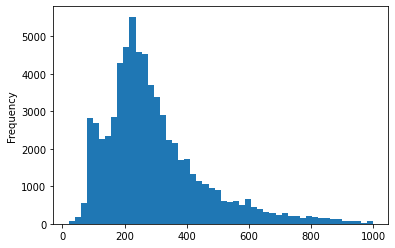

In [44]:
data_src[(data_src['num_words'] != 0) & (data_src['num_words'] < 1000)]['num_words'].plot.hist(bins=50)

In [45]:
data_src['num_words_hdl'] = data_src['Headlines'].apply(lambda x : len(x.split()))

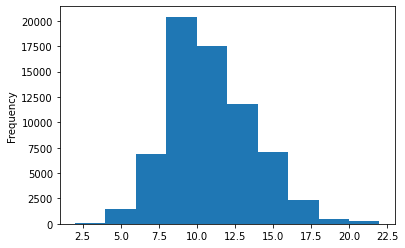

In [46]:
data_src['num_words_hdl'].plot.hist()

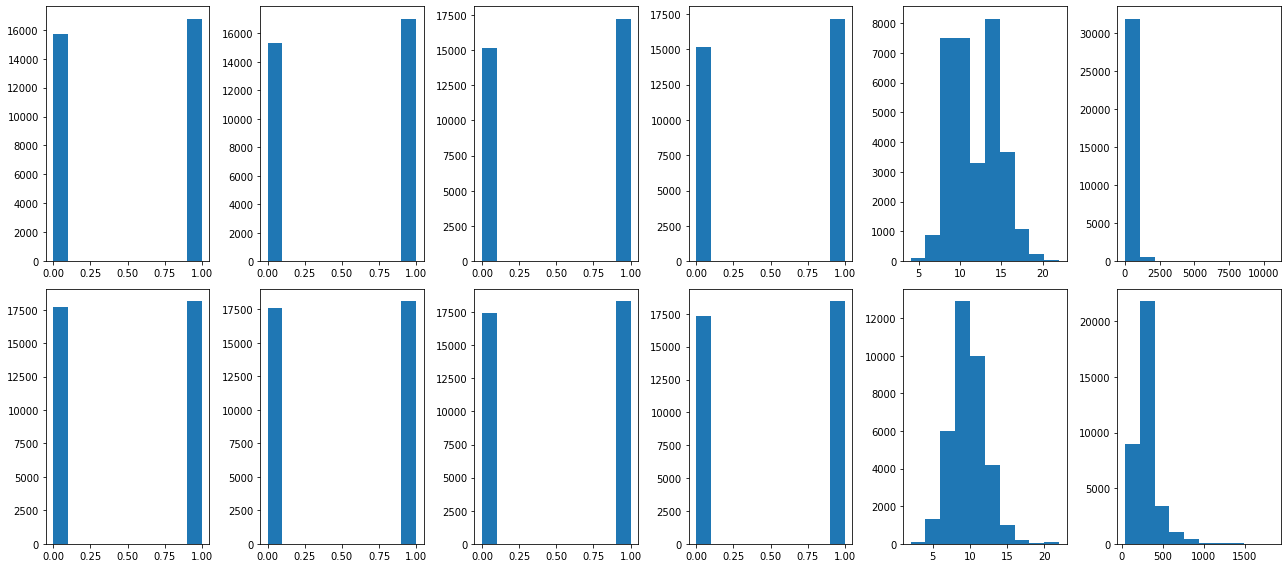

In [47]:
fig, axs = plt.subplots(2, 6, figsize=(18, 8), sharey=False)

axs[0][0].hist(data_src[data_src['Portal']=='MoneyControl']['target_d1'])
axs[0][1].hist(data_src[data_src['Portal']=='MoneyControl']['target_d2'])
axs[0][2].hist(data_src[data_src['Portal']=='MoneyControl']['target_d3'])
axs[0][3].hist(data_src[data_src['Portal']=='MoneyControl']['target_d4'])

axs[1][0].hist(data_src[data_src['Portal']=='TheHindu']['target_d1'])
axs[1][1].hist(data_src[data_src['Portal']=='TheHindu']['target_d2'])
axs[1][2].hist(data_src[data_src['Portal']=='TheHindu']['target_d3'])
axs[1][3].hist(data_src[data_src['Portal']=='TheHindu']['target_d4'])

axs[0][4].hist(data_src[data_src['Portal']=='MoneyControl']['num_words_hdl'])
axs[1][4].hist(data_src[data_src['Portal']=='TheHindu']['num_words_hdl'])

axs[0][5].hist(data_src[data_src['Portal']=='MoneyControl']['num_words'])
axs[1][5].hist(data_src[data_src['Portal']=='TheHindu']['num_words'])

plt.tight_layout()

In [48]:
print(len(data_src[data_src['num_words_hdl'] == 0]))

0


In [49]:
print(data_src.shape)
data_src = data_src[~np.isnan(data_src_main['target_d1']) & (data_src_main['Portal']=='MoneyControl')].copy()
print(data_src.shape)
data_src = data_src[data_src['num_words'] != 0].copy()
print(data_src.shape)

(68333, 29)
(32480, 29)
(32287, 29)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [53]:
print("Sections :",data_src['Sections'].value_counts())
print("ByLines :",data_src['ByLines'].value_counts())

Sections : Series([], Name: Sections, dtype: int64)
ByLines : Moneycontrol.com    24419
PTI                  6937
Reuters               591
CNBC-TV18             233
Mint                   79
Tech2                   5
Housing.com             5
Capitalmind             5
Hindustan Times         5
NEWS18.com              4
AP                      4
Name: ByLines, dtype: int64


In [63]:
data_src['Headlines_inptxt'] = data_src.apply(lambda x : x['Day'] + '. ' + x['ByLines'].replace(' ', '').replace('.', '_') + '. ' + x['Headlines'], axis=1)

In [64]:
data_src.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Day,close_d1,close_d2,close_d3,close_d4,change_d1,change_d2,change_d3,change_d4,target_d1,target_d2,target_d3,target_d4,input_day,Published_Dates,Headlines,Articles,ByLines,Portal,Sections,num_words,num_words_hdl,Headlines_inptxt
0,2019-01-07,1107.000000,1118.449951,1101.0,1104.750000,1094.612793,5513559.0,Monday,1104.650024,1110.75,1107.500000,1098.050049,-0.099976,6.000000,2.750000,-6.699951,0.0,1.0,1.0,0.0,0,2019-01-07,Jio continues to capture market share; Vodafon...,The entry of Reliance Jio Infocomm (Jio) had t...,Moneycontrol.com,MoneyControl,NaN,95,9,Monday. Moneycontrol_com. Jio continues to cap...
1,2019-01-07,1107.000000,1118.449951,1101.0,1104.750000,1094.612793,5513559.0,Monday,1104.650024,1110.75,1107.500000,1098.050049,-0.099976,6.000000,2.750000,-6.699951,0.0,1.0,1.0,0.0,0,2019-01-07,RIL gains nearly 2% after CLSA maintains buy r...,Global brokerage house CLSA has maintained buy...,Moneycontrol.com,MoneyControl,NaN,298,12,Monday. Moneycontrol_com. RIL gains nearly 2% ...
2,2019-01-08,1105.099976,1109.949951,1096.0,1104.650024,1094.513794,5625153.0,Tuesday,1110.750000,1107.50,1098.050049,1096.800049,6.099976,2.849976,-6.599975,-7.849975,1.0,1.0,0.0,0.0,1,2019-01-07,Jio continues to capture market share; Vodafon...,The entry of Reliance Jio Infocomm (Jio) had t...,Moneycontrol.com,MoneyControl,NaN,95,9,Tuesday. Moneycontrol_com. Jio continues to ca...


**Preprocessing Headline Text (with sample)**

In [61]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [65]:
sample_txt = data_src.iloc[0]['Headlines_inptxt']
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Input Text : {sample_txt}')
print(f'    Tokens : {tokens}')
print(f' Token IDs : {token_ids}')
print(f'Input Length : {len(sample_txt.split())}')
print(f'Token Length : {len(tokens)}')

Input Text : Monday. Moneycontrol_com. Jio continues to capture market share; Vodafone-Idea cedes ground
    Tokens : ['monday', '.', 'money', '##con', '##tro', '##l', '_', 'com', '.', 'ji', '##o', 'continues', 'to', 'capture', 'market', 'share', ';', 'vo', '##da', '##fo', '##ne', '-', 'idea', 'ce', '##des', 'ground']
 Token IDs : [6928, 1012, 2769, 8663, 13181, 2140, 1035, 4012, 1012, 10147, 2080, 4247, 2000, 5425, 3006, 3745, 1025, 29536, 2850, 14876, 2638, 1011, 2801, 8292, 6155, 2598]
Input Length : 11
Token Length : 26


In [68]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 32,
    add_special_tokens = True,
    padding='max_length',
    truncation=True,
    return_attention_mask = True,
    return_token_type_ids = False,
    return_tensors = 'pt'
)

In [69]:
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [70]:
print(f'     input_ids :', encoding['input_ids'])
print(f'attention_mask :', encoding['attention_mask'])

     input_ids : tensor([[  101,  6928,  1012,  2769,  8663, 13181,  2140,  1035,  4012,  1012,
         10147,  2080,  4247,  2000,  5425,  3006,  3745,  1025, 29536,  2850,
         14876,  2638,  1011,  2801,  8292,  6155,  2598,   102,     0,     0,
             0,     0]])
attention_mask : tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0]])


In [72]:
data_src['num_tokens_hdl'] = data_src['Headlines_inptxt'].apply(lambda x : len(tokenizer.encode_plus(x, max_length=512)['input_ids']))

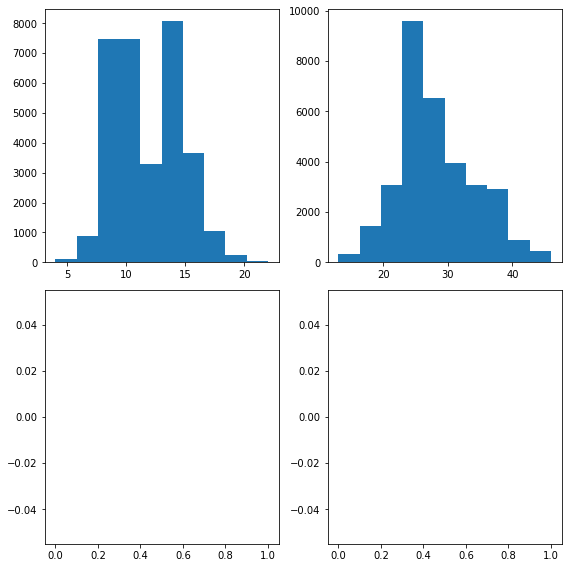

In [73]:
# This plot will be used to decide on a suitable sequence length for tokenization

fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharey=False)

axs[0][0].hist(data_src[data_src['Portal']=='MoneyControl']['num_words_hdl'])
axs[1][0].hist(data_src[data_src['Portal']=='TheHindu']['num_words_hdl'])

axs[0][1].hist(data_src[data_src['Portal']=='MoneyControl']['num_tokens_hdl'])
axs[1][1].hist(data_src[data_src['Portal']=='TheHindu']['num_tokens_hdl'])

plt.tight_layout()
# 'TheHindu' was explicitly removed, hence we have empty graphs now.

**Creating the Dataset (with sample)**

In [75]:
class headlineDataset(data.Dataset):

    def __init__(self, headline, target, tokenizer, max_len):
        self.headline = headline
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.headline)

    def __getitem__(self, item):
        headline = str(self.headline[item])

        encoding = tokenizer.encode_plus(
            headline,
            max_length = self.max_len,
            add_special_tokens = True,
            padding='max_length',
            truncation=True,
            return_attention_mask = True,
            return_token_type_ids = False,
            return_tensors = 'pt'
        )

        return {
            'headline' : headline,
            'input_ids' : encoding['input_ids'].flatten(),
            'attention_mask' : encoding['attention_mask'].flatten(),
            'targets' : torch.tensor(self.target[item], dtype = torch.long)
        }

In [76]:
MAX_LEN = 64
BATCH_SIZE = 32
EPOCHS = 10
RANDOM_SEED = 43

In [77]:
df_train, df_test = train_test_split(data_src, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [78]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    dset = headlineDataset(
        headline = df['Headlines_inptxt'].to_numpy(),
        target = df['target_d1'].to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )

    return data.DataLoader(
        dset,
        batch_size = batch_size,
        num_workers = 4
    )

In [79]:
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)

In [80]:
data_sample = next(iter(train_data_loader))
data_sample.keys()

dict_keys(['headline', 'input_ids', 'attention_mask', 'targets'])

In [81]:
print(data_sample['input_ids'].shape)
print(data_sample['attention_mask'].shape)
print(data_sample['targets'].shape)

torch.Size([32, 64])
torch.Size([32, 64])
torch.Size([32])


**BERT Model (sample output)**

In [82]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [83]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [84]:
bertout = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
)
last_hidden_state, pooled_output = bertout[0], bertout[1]

In [85]:
print(encoding['input_ids'].shape)
print(last_hidden_state.shape)
print(pooled_output.shape)

torch.Size([1, 32])
torch.Size([1, 32, 768])
torch.Size([1, 768])


In [86]:
bert_model.config.hidden_size

768

**Building a Text Classifier**

In [87]:
class textClassifier(nn.Module):

    def __init__(self, n_classes):
        super(textClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask
        )[1]
        output = self.drop(pooled_output)
        output = self.out(output)
        return output

In [88]:
num_class = 2 # 0 is for 'down' and 1 is for 'up' movement of stock.
model = textClassifier(num_class)
model = model.to(device)

In [89]:
input_ids = data_sample['input_ids'].to(device)
attention_mask = data_sample['attention_mask'].to(device)

print(input_ids.shape)
print(attention_mask.shape)

torch.Size([32, 64])
torch.Size([32, 64])


In [90]:
# Checking the outputs of bert model on this sample batch of input data
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5748, 0.4252],
        [0.6030, 0.3970],
        [0.5319, 0.4681],
        [0.6380, 0.3620],
        [0.5162, 0.4838],
        [0.4029, 0.5971],
        [0.3307, 0.6693],
        [0.5470, 0.4530],
        [0.5810, 0.4190],
        [0.5159, 0.4841],
        [0.5789, 0.4211],
        [0.4935, 0.5065],
        [0.6290, 0.3710],
        [0.4799, 0.5201],
        [0.4470, 0.5530],
        [0.4870, 0.5130],
        [0.6404, 0.3596],
        [0.6121, 0.3879],
        [0.5973, 0.4027],
        [0.5086, 0.4914],
        [0.5924, 0.4076],
        [0.6086, 0.3914],
        [0.5190, 0.4810],
        [0.5068, 0.4932],
        [0.4787, 0.5213],
        [0.5613, 0.4387],
        [0.3409, 0.6591],
        [0.4752, 0.5248],
        [0.4990, 0.5010],
        [0.5323, 0.4677],
        [0.3907, 0.6093],
        [0.4341, 0.5659]], device='cuda:0', grad_fn=<SoftmaxBackward>)

**Training the Classifier**

In [91]:
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader)*EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [92]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        targets = d['targets'].to(device)
    
        outputs = model(
            input_ids = input_ids,
            attention_mask = attention_mask
        )

        _, pred = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(pred == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double()/n_examples, np.mean(losses)

In [93]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
        
            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask
            )

            _, pred = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(pred == targets)
            losses.append(loss.item())

    return correct_predictions.double()/n_examples, np.mean(losses)

In [94]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))

    print(f'Train Loss : {train_loss} Accuracy : {train_acc}')

    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))

    print(f'  Val Loss : {val_loss} Accuracy : {val_acc}')
    print()

    history['train_acc'].append('train_acc')
    history['train_loss'].append('train_loss')
    history['val_acc'].append('val_acc')
    history['val_loss'].append('val_loss')

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'bert_base_uncased_p1_headline.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train Loss : 0.7017640854315003 Accuracy : 0.502768206279763
  Val Loss : 0.6926503742095267 Accuracy : 0.5193558377206565

Epoch 2/10
----------
Train Loss : 0.6958451373594823 Accuracy : 0.505246041271439
  Val Loss : 0.6919348039249382 Accuracy : 0.5174976772994735

Epoch 3/10
----------
Train Loss : 0.6913689468609224 Accuracy : 0.5294436486120252
  Val Loss : 0.6895234272031501 Accuracy : 0.5320532672654072

Epoch 4/10
----------
Train Loss : 0.6801955845981541 Accuracy : 0.5674242130938093
  Val Loss : 0.6949587234176031 Accuracy : 0.5305048002477547

Epoch 5/10
----------
Train Loss : 0.6595575280930146 Accuracy : 0.6064113980409617
  Val Loss : 0.7156173769790347 Accuracy : 0.5240012387736142

Epoch 6/10
----------
Train Loss : 0.6395130550654808 Accuracy : 0.6316930581904061
  Val Loss : 0.7492890505507441 Accuracy : 0.5264787860018582

Epoch 7/10
----------
Train Loss : 0.6238465509792366 Accuracy : 0.6484184443842193
  Val Loss : 0.7635898100267543 Accu

**Evaluation**

In [95]:
def get_stocktrend(model, data_loader):
    model = model.eval()

    headline_txt = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            headline = d['Headlines_inptxt']
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            targets = d['targets'].to(device)
        
            outputs = model(
                input_ids = input_ids,
                attention_mask = attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            headline_txt.extend(headline)
            predictions.extend(pred)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    return headline_txt, predictions, prediction_probs, real_values

In [96]:
test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
print('Test Accuracy :', test_acc)

Test Accuracy : tensor(0.5361, device='cuda:0', dtype=torch.float64)


In [100]:
y_headline_txt, y_pred, y_pred_probs, y_test = get_stocktrend(model, test_data_loader)

KeyError: ignored

In [98]:
print(classification_report(y_test, y_pred, target_names=['Stock Mvm. Down', 'Stock Mvm. Up']))

NameError: ignored

In [99]:
!nvidia-smi

Wed Feb 10 11:05:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    32W /  70W |   5765MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------